## Main Code for Data Import, Clean and Analysis

In [2]:
#Dependencies

import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table
import seaborn as sns
import datetime as dt
from scipy.stats import linregress
import json
import requests
from api_keys import api_key

## Data Import and Clean

In [3]:
#crime statistics data
file = "datasource/WA Police Force Crime Timeseries.xlsx"
WAstats = pd.read_excel(file,sheet_name = "Data")
#fillna with 0 for 0 crime counts
WAstats.fillna(0, inplace = True)

In [4]:
#estimated resident population data
erpfile = "datasource/ERP.xls"
erp = pd.read_excel(erpfile,sheet_name = "Sheet1", header=2)
#drop nas for blank years
erp.dropna(inplace = True)
#change year column to datetime format
erp['Year (ending June 30)'] = pd.to_datetime(erp['Year (ending June 30)'], format='%Y')

In [5]:
#get dv related homeless services provided
sasfile = "datasource/sasexport.xlsx"
dvhomeless = pd.read_excel(sasfile,sheet_name = "Sheet1",header=3)
#fill in state data downwards
dvhomeless.fillna(method='ffill', inplace=True)

In [6]:
#get google search trends on domestic violence
googlefile = "datasource/wadvsearch.csv"
dvgoogle = pd.read_csv(googlefile, header = 1)
dvgoogle['Month/Year'] = pd.to_datetime(dvgoogle['Week'], dayfirst=True).dt.to_period('M')
dvgooglemonthly = dvgoogle.groupby('Month/Year')['Domestic violence: (Western Australia)'].sum().reset_index()


googlerespectfile = "datasource/1800respect.csv"
respectsearch = pd.read_csv(googlerespectfile, header = 2)
respectsearch['Month/Year'] = pd.to_datetime(respectsearch['Week'], dayfirst=True).dt.to_period('M')
respectmonthly = respectsearch.groupby('Month/Year')['1800 respect: (Australia)'].sum().reset_index()


In [7]:
#population df manually created from website query data
population = {'Website Region' : ['Goldfields-Esperance District', 'Great Southern District',
        'Kimberley District',
       'Metropolitan Region', 'Mid West-Gascoyne District',
       'Pilbara District', 'South West District', 'Wheatbelt District','Western Australia'],
    'Population': [54363, 60993,35901,1900000, 62932,62093, 179791, 73437,2663561]}
pop_df = pd.DataFrame(population)

In [25]:
#guardian news api
url = f'https://content.guardianapis.com/search?q=domestic%20AND%20violence%20AND%20(lockdown%20OR%20coronavirus)&from-date=2020-03-01&page-size=200&api-key={api_key}'

response = requests.get(url)
news_json = response.json()


In [26]:
#print output
print(json.dumps(news_json, indent=4, sort_keys=True))

{
    "response": {
        "currentPage": 1,
        "orderBy": "relevance",
        "pageSize": 200,
        "pages": 5,
        "results": [
            {
                "apiUrl": "https://content.guardianapis.com/world/2021/mar/23/tuesday-briefing-domestic-abuse-lockdown",
                "id": "world/2021/mar/23/tuesday-briefing-domestic-abuse-lockdown",
                "isHosted": false,
                "pillarId": "pillar/news",
                "pillarName": "News",
                "sectionId": "world",
                "sectionName": "World news",
                "type": "article",
                "webPublicationDate": "2021-03-23T06:25:44Z",
                "webTitle": "Tuesday briefing: Domestic abuse reports surge amid lockdown",
                "webUrl": "https://www.theguardian.com/world/2021/mar/23/tuesday-briefing-domestic-abuse-lockdown"
            },
            {
                "apiUrl": "https://content.guardianapis.com/society/2021/mar/23/domestic-abuse-covid-lock

In [27]:
#print out headlines from first page
headlines = []
for r in news_json["response"]['results']:
    headlines.append(r['webTitle'])

In [28]:
#get total numer of dv and lockdown related articles
numberofarticles = news_json["response"]["pageSize"] * news_json["response"]["pages"]
print(numberofarticles)

1000


In [29]:
#dataframe of headslines from first page of API call
headlinedf = pd.DataFrame(headlines)
headlinedf.rename(columns={0:'Selection from 200 headlines relating to domestic violence and lockdown'}, inplace=True)

In [46]:
#put headlines in table
headlinedf.to_csv("output/headlines.csv", encoding = "utf-8", index=False)
headlinedf.head(15)

,Selection from 200 headlines relating to domestic violence and lockdown
0,Tuesday briefing: Domestic abuse reports surge...
1,Calls to domestic abuse helpline in England up...
2,Man who killed wife 'in act of great violence'...
3,"Morning mail: Quarantine complacency, Kidman o..."
4,Domestic abusers to get GPS tags on release fr...
5,Shock new figures fuel fears of more lockdown ...
6,Women killed in Spain as coronavirus lockdown ...
7,Fears grow for those facing domestic abuse as ...
8,Labour urges Patel to act on domestic abuse du...
9,Lockdown may have played part in rise of domes...


In [30]:
#list of regions
regionlist = WAstats['Website Region'].unique()
regionlist

array(['Armadale District', 'Cannington District', 'Fremantle District',
       'Goldfields-Esperance District', 'Great Southern District',
       'Joondalup District', 'Kimberley District', 'Mandurah District',
       'Metropolitan Region', 'Mid West-Gascoyne District',
       'Midland District', 'Mirrabooka District', 'Perth District',
       'Pilbara District', 'Regional WA Region', 'South West District',
       'Western Australia', 'Wheatbelt District'], dtype=object)

In [31]:
#list of crimes lvl2
basiccrimedesc = WAstats['WAPOL_Hierarchy_Lvl2'].unique()
basiccrimedesc

array(['Homicide', 'Recent Sexual Offences', 'Historical Sexual Offences',
       'Assault (Family)', 'Assault (Non-Family)',
       'Threatening Behaviour (Family)',
       'Threatening Behaviour (Non-Family)', 'Deprivation of Liberty',
       'Robbery', 'Burglary', 'Stealing of Motor Vehicle', 'Stealing',
       'Property Damage', 'Arson', 'Drug Offences',
       'Receiving and Possession of Stolen Property',
       'Regulated Weapons Offences', 'Graffiti',
       'Fraud & Related Offences', 'Breach of Violence Restraint Order'],
      dtype=object)

In [132]:
WAstats.head()

,Website Region,WAPOL_Hierarchy_order_Lvl1,WAPOL_Hierarchy_Lvl1,WAPOL_Hierarchy_order_Lvl2,WAPOL_Hierarchy_Lvl2,Period,Year,Key,MonthYear,COUNT_of_Offnc_ID
0,Armadale District,1.1,Murder,1,Homicide,2007-01-01,2006-07,Armadale DistrictMurderHomicide12007,12007,0.0
1,Armadale District,1.1,Murder,1,Homicide,2007-02-01,2006-07,Armadale DistrictMurderHomicide22007,22007,0.0
2,Armadale District,1.1,Murder,1,Homicide,2007-03-01,2006-07,Armadale DistrictMurderHomicide32007,32007,1.0
3,Armadale District,1.1,Murder,1,Homicide,2007-04-01,2006-07,Armadale DistrictMurderHomicide42007,42007,0.0
4,Armadale District,1.1,Murder,1,Homicide,2007-05-01,2006-07,Armadale DistrictMurderHomicide52007,52007,0.0


In [8]:
#All WA stats from 2019
WAstats2019 = WAstats[WAstats["Period"]>dt.datetime(year=2019, month = 1, day = 1)]


In [9]:
#key crimes list
TopCrimes = WAstats.groupby('WAPOL_Hierarchy_Lvl2')["COUNT_of_Offnc_ID"].sum().sort_values(ascending = False)
keycrimes = TopCrimes[0:6].index.tolist()
keycrimes

['Stealing',
 'Property Damage',
 'Burglary',
 'Drug Offences',
 'Fraud & Related Offences',
 'Assault (Family)']

In [10]:
#grouped into region, time period and Lvl 2 crime
Grouped = WAstats.groupby(['Website Region','Period','WAPOL_Hierarchy_Lvl2'])['COUNT_of_Offnc_ID'].sum().reset_index()
#merge with population 
GroupedRates = pd.merge(Grouped, pop_df,on='Website Region')
#calculate crime rate
GroupedRates['Rate'] = GroupedRates['COUNT_of_Offnc_ID']/(GroupedRates['Population'])*100000
#preview dataframe
GroupedRates.head()

,Website Region,Period,WAPOL_Hierarchy_Lvl2,COUNT_of_Offnc_ID,Population,Rate
0,Goldfields-Esperance District,2007-01-01,Arson,5.0,54363,9.197432
1,Goldfields-Esperance District,2007-01-01,Assault (Family),63.0,54363,115.887644
2,Goldfields-Esperance District,2007-01-01,Assault (Non-Family),71.0,54363,130.603535
3,Goldfields-Esperance District,2007-01-01,Breach of Violence Restraint Order,14.0,54363,25.752810
4,Goldfields-Esperance District,2007-01-01,Burglary,168.0,54363,309.033718


## Visualisations

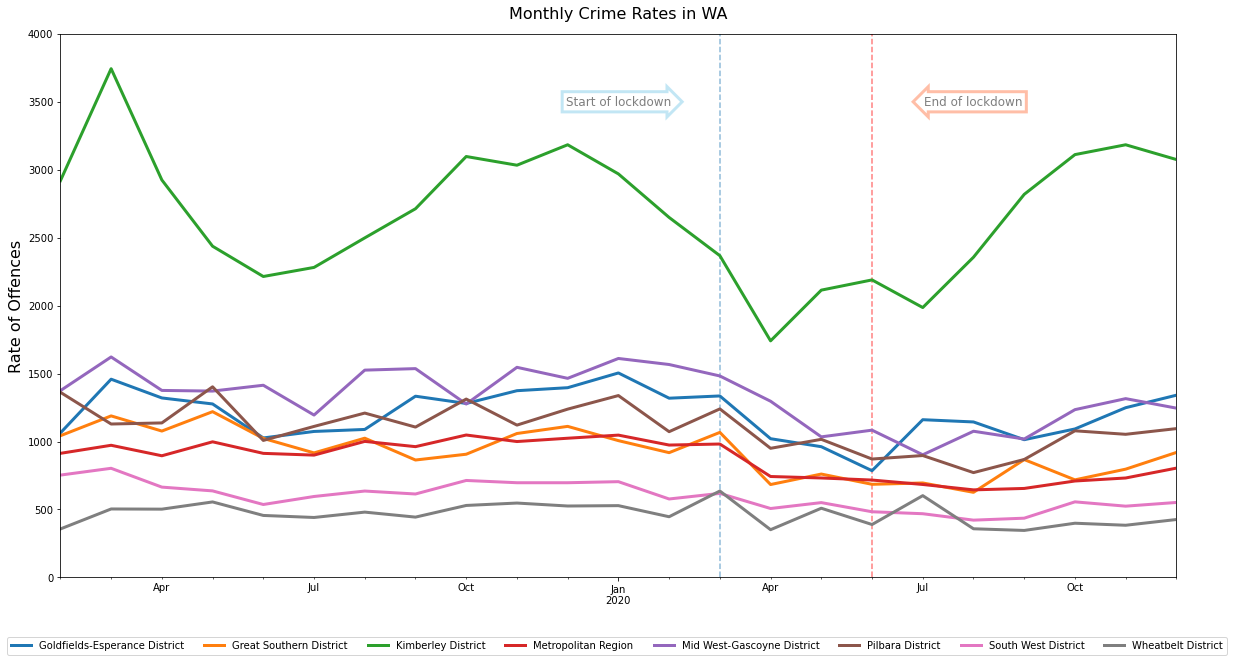

In [71]:
#get total crime rate per region from 2019
From2019 = GroupedRates[GroupedRates["Period"]>dt.datetime(year=2019, month = 1, day = 1)]
TotalCrimeRate = From2019.groupby(['Website Region','Period'])['Rate'].sum().reset_index()
RegionalCrimeRate = TotalCrimeRate[(TotalCrimeRate['Website Region']!='Western Australia')]
#pivot for graphing
TotalCrimesPivot = RegionalCrimeRate.pivot(index='Period', columns='Website Region', values='Rate')
#make chart
TotalCrimesPivot.plot(figsize=(20,10),linewidth=3)
plt.legend(bbox_to_anchor = (1.05, -0.1), ncol=8)
plt.text(
    "2020-01", 3500, "Start of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=12,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="skyblue", alpha=0.5, lw=3))
plt.text(
    "2020-08", 3500, "End of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=12,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="coral", alpha=0.5, lw=3))
plt.vlines("2020-03",ymin = 0, ymax = 4000,linestyles='dashed', alpha=0.5)
plt.vlines("2020-06",ymin = 0, ymax = 4000, colors ="red",linestyles='dashed', alpha=0.5)
plt.ylim(0,4000)
plt.title("Monthly Crime Rates in WA", fontsize= 16,pad=15)
plt.ylabel("Rate of Offences",fontsize=16)
plt.xlabel('')
plt.savefig("output/crimeratesregions.png",bbox_inches='tight')
plt.show()

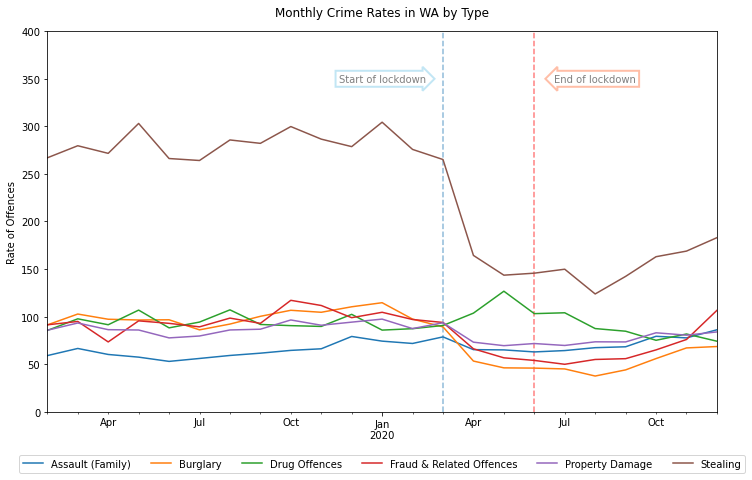

In [22]:
#get rates of key crimes
WARate = From2019[From2019['Website Region']=='Western Australia']
CrimeTypeRate = WARate[WARate['WAPOL_Hierarchy_Lvl2'].isin(keycrimes)]
CrimeTypeRate = CrimeTypeRate.groupby(['WAPOL_Hierarchy_Lvl2','Period'])['Rate'].sum().reset_index()
#pivot for graphing
CrimesPivot = CrimeTypeRate.pivot(index='Period', columns='WAPOL_Hierarchy_Lvl2', values='Rate')
#make chart
CrimesPivot.plot(figsize=(12,7))
plt.legend(bbox_to_anchor = (1.05, -0.1),ncol=6)
plt.text(
    "2020-01", 350, "Start of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="skyblue", alpha=0.5, lw=2))
plt.text(
    "2020-08", 350, "End of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="coral", alpha=0.5, lw=2))
plt.vlines("2020-03",ymin = 0, ymax = 500,linestyles='dashed', alpha=0.5)
plt.vlines("2020-06",ymin = 0, ymax = 500, colors ="red",linestyles='dashed', alpha=0.5)
plt.ylim(0,400)
plt.title("Monthly Crime Rates in WA by Type", pad=15)
plt.ylabel("Rate of Offences")
plt.xlabel("")
plt.savefig("output/crimetyperatesregions.png",bbox_inches='tight')
plt.show()

In [34]:
#set time frames of pre, into and post lockdown #####FIX#####
timeframescrime = WARate[(WARate['Period']=='2020-02')|(WARate['Period']=='2020-05')|(WARate['Period']=='2020-07')]
timeframescrime = timeframescrime[["WAPOL_Hierarchy_Lvl2",'Period','Rate']]
timeframescrime= timeframescrime.pivot(index='Period', columns='WAPOL_Hierarchy_Lvl2', values='Rate')

timeframescrime

WAPOL_Hierarchy_Lvl2,Arson,Assault (Family),Assault (Non-Family),Breach of Violence Restraint Order,Burglary,Deprivation of Liberty,Drug Offences,Fraud & Related Offences,Graffiti,Historical Sexual Offences,Homicide,Property Damage,Receiving and Possession of Stolen Property,Recent Sexual Offences,Regulated Weapons Offences,Robbery,Stealing,Stealing of Motor Vehicle,Threatening Behaviour (Family),Threatening Behaviour (Non-Family)
Period,,,,,,,,,,,,,,,,,,,,
2020-02-01,3.303848,71.783601,42.274234,37.768987,97.388421,0.713331,87.326703,96.975440,5.706646,3.341391,0.337894,87.401790,11.751186,11.901361,11.000311,4.017179,275.758655,22.451147,9.085581,11.525923
2020-05-01,3.078585,65.025731,34.390052,41.260553,46.141237,0.638243,126.710070,56.691024,6.082083,9.761368,0.375437,69.455890,13.065216,19.747999,14.266615,4.054722,143.567202,11.601011,10.061718,10.962768
2020-07-01,2.440342,64.312400,39.458454,37.055656,45.014926,0.863506,104.033660,49.895610,5.894365,7.095764,0.412981,69.681152,9.761368,14.379246,11.188030,2.628061,149.837004,11.788729,9.461019,9.611193


In [48]:
#get percentage change crime
crimechange = timeframescrime.pct_change().multiply(100).round(2)
crimechange.reset_index(inplace=True)
crimesin = crimechange[crimechange['Period']=='2020-05-01']
crimesin = crimesin.T.drop(labels="Period", axis=0)
crimesin.to_csv("output/crimesinto.csv", encoding = "utf-8", index=True)
crimesin.sort_values(by=[1])

,1
WAPOL_Hierarchy_Lvl2,
Burglary,-52.62
Stealing of Motor Vehicle,-48.33
Stealing,-47.94
Fraud & Related Offences,-41.54
Property Damage,-20.53
Assault (Non-Family),-18.65
Deprivation of Liberty,-10.53
Assault (Family),-9.41
Arson,-6.82


In [51]:
crimesout = crimechange[crimechange['Period']=='2020-07-01']
crimesout = crimesout.T.drop(labels="Period", axis=0)
crimesout.to_csv("output/crimesout.csv", encoding = "utf-8", index=True)
crimesout.sort_values(by=[2])

,2
WAPOL_Hierarchy_Lvl2,
Robbery,-35.19
Historical Sexual Offences,-27.31
Recent Sexual Offences,-27.19
Receiving and Possession of Stolen Property,-25.29
Regulated Weapons Offences,-21.58
Arson,-20.73
Drug Offences,-17.9
Threatening Behaviour (Non-Family),-12.33
Fraud & Related Offences,-11.99


In [42]:
#Whealbelt Region only
WBR = From2019[From2019['Website Region']=='Wheatbelt District']
TopCrimesWBR = WBR.groupby('WAPOL_Hierarchy_Lvl2')["COUNT_of_Offnc_ID"].sum().sort_values(ascending = False)
keycrimesWBR = TopCrimes[0:6].index.tolist()
keycrimesWBR

['Stealing',
 'Property Damage',
 'Burglary',
 'Drug Offences',
 'Fraud & Related Offences',
 'Assault (Family)']

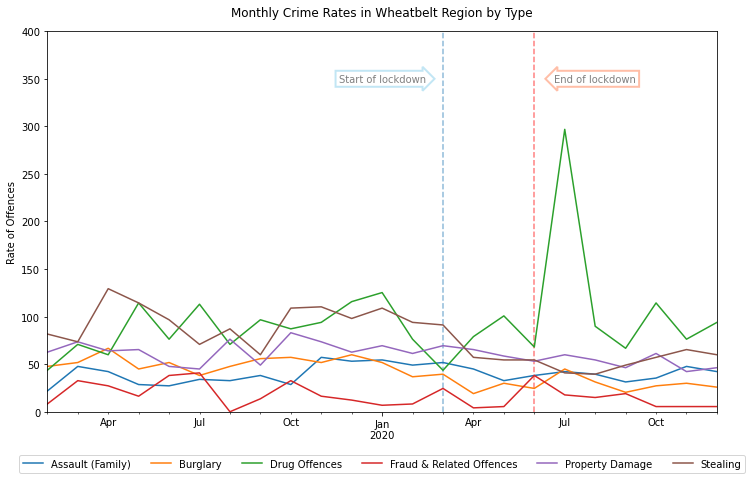

In [56]:
#get rates of key crimes
WBRkey = WBR[WBR['WAPOL_Hierarchy_Lvl2'].isin(keycrimesWBR)]
WBRkey = WBRkey.groupby(['Period','WAPOL_Hierarchy_Lvl2'])['Rate'].sum().reset_index()
#pivot for graphing
WBRPivot = WBRkey.pivot(index='Period', columns='WAPOL_Hierarchy_Lvl2', values='Rate')
#make chart
WBRPivot.plot(figsize=(12,7))
plt.legend(bbox_to_anchor = (1.05, -0.1), ncol=6)
plt.text(
    "2020-01", 350, "Start of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="skyblue", alpha=0.5, lw=2))
plt.text(
    "2020-08", 350, "End of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="coral", alpha=0.5, lw=2))
plt.vlines("2020-03",ymin = 0, ymax = 500,linestyles='dashed', alpha=0.5)
plt.vlines("2020-06",ymin = 0, ymax = 500, colors ="red",linestyles='dashed', alpha=0.5)
plt.ylim(0,400)
plt.title("Monthly Crime Rates in Wheatbelt Region by Type", pad=15)
plt.ylabel("Rate of Offences")
plt.xlabel('')
plt.savefig("output/wbrcrimerates.png",bbox_inches='tight')
plt.show()

In [44]:
#set time frames of pre, into and post lockdown
timeframes = TotalCrimeRate[(TotalCrimeRate['Period']=='2020-02')|(TotalCrimeRate['Period']=='2020-05')|(TotalCrimeRate['Period']=='2020-07')]
timeframes = timeframes[["Website Region",'Period','Rate']]
timeframes.head()


,Website Region,Period,Rate
12,Goldfields-Esperance District,2020-02-01,1318.911760
15,Goldfields-Esperance District,2020-05-01,962.051395
17,Goldfields-Esperance District,2020-07-01,1160.715928
35,Great Southern District,2020-02-01,918.138147
38,Great Southern District,2020-05-01,760.743036


In [45]:
#get percentage change
overallchange = timeframes.set_index(["Website Region",'Period']).pct_change().multiply(100).round(2)
overallchange.reset_index(inplace=True)
overallchange.head()

,Website Region,Period,Rate
0,Goldfields-Esperance District,2020-02-01,NaN
1,Goldfields-Esperance District,2020-05-01,-27.06
2,Goldfields-Esperance District,2020-07-01,20.65
3,Great Southern District,2020-02-01,-20.90
4,Great Southern District,2020-05-01,-17.14


In [47]:
#get data into separate tables for map plotting
Regionsinto = overallchange[overallchange['Period']=='2020-05-01']
Regionsout = overallchange[overallchange['Period']=='2020-07-01']
Regionsinto.to_csv("output/Regionsinto.csv", encoding = "utf-8", index=False)
Regionsout.to_csv("output/Regionsout.csv", encoding = "utf-8", index=False)

In [48]:
Regionsinto.describe()

,Rate
count,9.000000
mean,-15.785556
std,14.736672
min,-33.980000
25%,-24.870000
50%,-20.190000
75%,-5.260000
max,14.020000


In [49]:
print(Regionsinto.loc[Regionsinto['Rate'].idxmax(axis=0)])
print(Regionsinto.loc[Regionsinto['Rate'].idxmin(axis=0)])


Website Region     Wheatbelt District
Period            2020-05-01 00:00:00
Rate                            14.02
Name: 25, dtype: object
Website Region    Mid West-Gascoyne District
Period                   2020-05-01 00:00:00
Rate                                  -33.98
Name: 13, dtype: object


In [82]:
Regionsinto.sort_values("Rate")

,Website Region,Period,Rate
13,Mid West-Gascoyne District,2020-05-01,-33.98
1,Goldfields-Esperance District,2020-05-01,-27.06
10,Metropolitan Region,2020-05-01,-24.87
22,Western Australia,2020-05-01,-22.97
7,Kimberley District,2020-05-01,-20.19
4,Great Southern District,2020-05-01,-17.14
16,Pilbara District,2020-05-01,-5.26
19,South West District,2020-05-01,-4.62
25,Wheatbelt District,2020-05-01,14.02


In [54]:
#get domestic violence data per region
Domesticviolence = GroupedRates[((GroupedRates["WAPOL_Hierarchy_Lvl2"]=="Assault (Family)")|(GroupedRates["WAPOL_Hierarchy_Lvl2"]=="Threatening Behaviour (Family)"))] 
Domesticviolence = Domesticviolence.replace({'Assault (Family)':'Domestic Violence','Threatening Behaviour (Family)':'Domestic Violence'})
Domesticviolence = Domesticviolence.groupby(["Website Region",'Period','WAPOL_Hierarchy_Lvl2'])['Rate'].sum().reset_index()
Domesticviolencecovid = Domesticviolence[((Domesticviolence["Period"]=="2020-02")|(Domesticviolence["Period"]=="2020-05")|(Domesticviolence["Period"]=="2020-07"))]


In [55]:
Domesticviolencecovid.head()

,Website Region,Period,WAPOL_Hierarchy_Lvl2,Rate
157,Goldfields-Esperance District,2020-02-01,Domestic Violence,172.911723
160,Goldfields-Esperance District,2020-05-01,Domestic Violence,185.788128
162,Goldfields-Esperance District,2020-07-01,Domestic Violence,204.182992
325,Great Southern District,2020-02-01,Domestic Violence,113.127736
328,Great Southern District,2020-05-01,Domestic Violence,108.209139


In [56]:
#get % change in dv between time periods
Domesticviolencechange = Domesticviolencecovid.drop(columns="WAPOL_Hierarchy_Lvl2").set_index(["Website Region",'Period']).pct_change().multiply(100).round(2)

In [57]:
Domesticviolencechange.reset_index(inplace=True)

In [58]:
#get dv % change for each time period
Regionsdvin = Domesticviolencechange[Domesticviolencechange['Period']=='2020-05']
Regionsdvout = Domesticviolencechange[Domesticviolencechange['Period']=='2020-07']

In [59]:
Regionsdvin.describe()

,Rate
count,9.000000
mean,-6.126667
std,14.849687
min,-33.330000
25%,-11.350000
50%,-4.350000
75%,2.940000
max,12.450000


In [126]:
print(Regionsdvin.loc[Regionsdvin['Rate'].idxmax(axis=0)])
print(Regionsdvin.loc[Regionsdvin['Rate'].idxmin(axis=0)])

Website Region     Kimberley District
Period            2020-05-01 00:00:00
Rate                            12.45
Name: 7, dtype: object
Website Region     Wheatbelt District
Period            2020-05-01 00:00:00
Rate                           -33.33
Name: 25, dtype: object


In [127]:
#save to csv for map plot
Regionsdvin.to_csv("output/Regionsdvinto.csv", encoding = "utf-8", index=False)
Regionsdvout.to_csv("output/Regionsdvout.csv", encoding = "utf-8", index=False)

In [60]:
#pivot for graphing
Domesticviolence2019 = Domesticviolence[Domesticviolence["Period"]>dt.datetime(year=2019, month = 1, day = 1)]
DomesticviolenceRegion = Domesticviolence2019[Domesticviolence2019['Website Region']!='Western Australia']
DVpivot = DomesticviolenceRegion.drop(columns=["WAPOL_Hierarchy_Lvl2"]).pivot(index='Period', columns='Website Region', values='Rate')

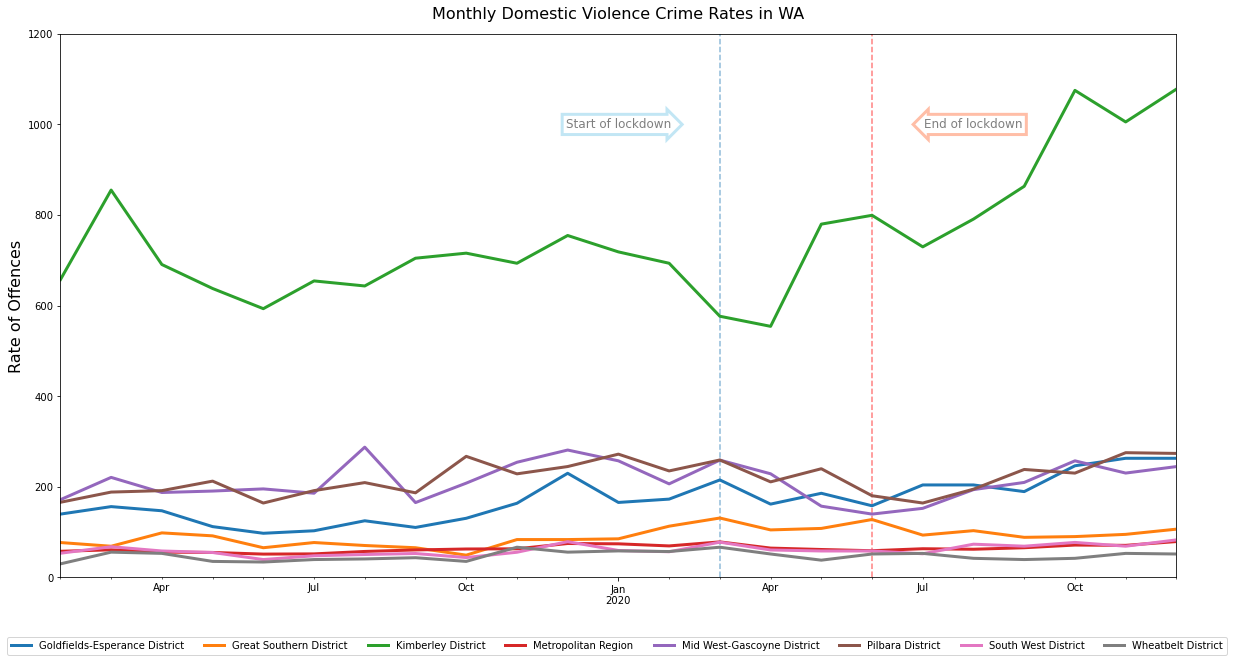

In [69]:
#plot dv chart
DVpivot.plot(figsize=(20,10),linewidth=3)
plt.legend(bbox_to_anchor = (1.05, -0.1),ncol=8)
plt.text(
    "2020-01", 1000, "Start of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=12,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="skyblue", alpha=0.5, lw=3))
plt.text(
    "2020-08", 1000, "End of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=12,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="coral", alpha=0.5, lw=3))
plt.vlines("2020-03",ymin = 0, ymax = 1200,linestyles='dashed', alpha=0.5)
plt.vlines("2020-06",ymin = 0, ymax = 1200, colors ="red",linestyles='dashed', alpha=0.5)
plt.ylim(0,1200)
plt.title("Monthly Domestic Violence Crime Rates in WA",fontsize=16, pad=15)
plt.ylabel("Rate of Offences",fontsize=16)
plt.xlabel("")
plt.savefig("output/dvratesregions.png",bbox_inches='tight')
plt.show()

In [135]:
#DV in WA total
DomesticviolenceWA = Domesticviolence[Domesticviolence['Website Region']=='Western Australia']

In [136]:
#merge crime rates with google searches
dvsearches = pd.merge(DomesticviolenceWA,dvgooglemonthly, how='inner', left_on = DomesticviolenceWA['Period'].dt.strftime('%Y-%m'),right_on = dvgooglemonthly['Month/Year'].dt.strftime('%Y-%m'))
allsearches = pd.merge(dvsearches,respectmonthly, on= 'Month/Year')
allsearches.rename(columns ={'Rate':'Domestic Violence Offences','Domestic violence: (Western Australia)':'Google Searches for domestic violence in Western Australia','1800 respect: (Australia)':'Google Searches for 1800 respect in Australia'}, inplace=True)
allsearches2019 = allsearches[allsearches["Period"]>dt.datetime(year=2019, month = 1, day = 1)]

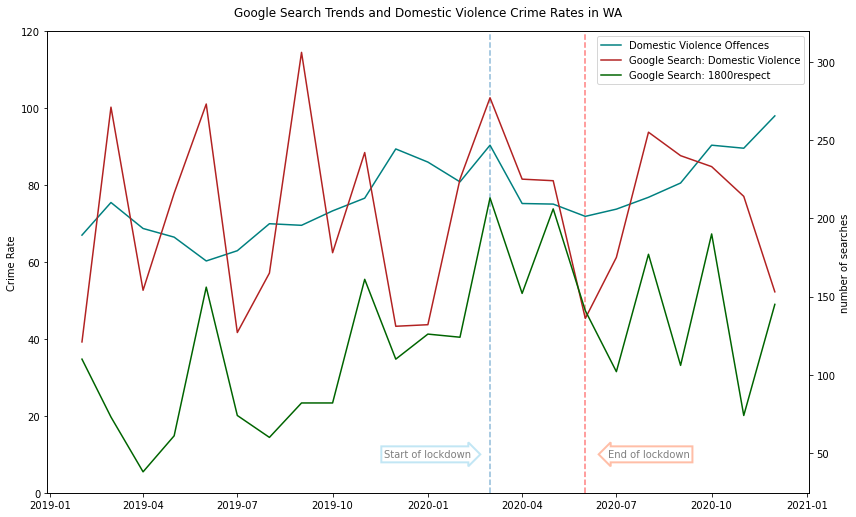

In [137]:
#plot crime and search data
fig, ax1 = plt.subplots(figsize=(12,7))


ax1.set_ylabel('Crime Rate')
ax1.plot(allsearches2019['Period'], allsearches2019['Domestic Violence Offences'],label = 'Domestic Violence Offences',color='teal')


ax2 = ax1.twinx() 

ax2.set_ylabel('number of searches')  
ax2.plot(allsearches2019['Period'], allsearches2019['Google Searches for domestic violence in Western Australia'],label = 'Google Search: Domestic Violence',color ='firebrick')
ax2.plot(allsearches2019['Period'], allsearches2019['Google Searches for 1800 respect in Australia'],label = 'Google Search: 1800respect',color ='darkgreen')

ax1.text(
    dt.datetime(year=2020, month = 1,day=1), 10, "Start of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="skyblue", alpha=0.5, lw=2))
ax1.text(
    dt.datetime(year=2020, month = 8,day=1), 10, "End of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="coral", alpha=0.5, lw=2))
ax1.vlines(dt.datetime(year=2020, month = 3,day=1),ymin = 0, ymax = 150,linestyles='dashed', alpha=0.5)
ax1.vlines(dt.datetime(year=2020, month = 6,day=1),ymin = 0, ymax = 150, colors ="red",linestyles='dashed', alpha=0.5)
ax1.set_ylim(0,120)
fig.tight_layout() 
plt.title('Google Search Trends and Domestic Violence Crime Rates in WA', pad=15)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax1.legend(lines, labels, loc=0)
plt.savefig("output/googlesearchtrends.png",bbox_inches='tight')
plt.show()

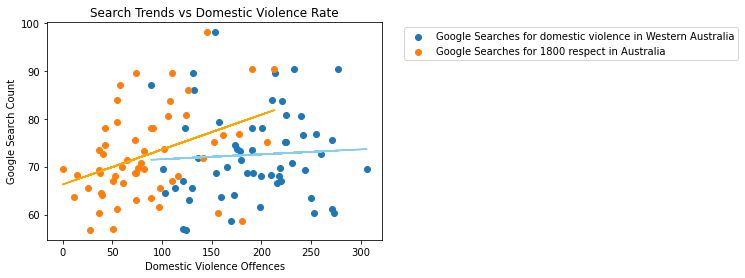

In [151]:
#regression to compare searches to rates
a=allsearches['Google Searches for domestic violence in Western Australia']
b=allsearches['Domestic Violence Offences']
c=allsearches['Google Searches for 1800 respect in Australia']

(aslope, aintercept, arvalue, apvalue, astderr) = linregress(a, b)
aregress_values = a * aslope + aintercept
aline_eq = "y = " + str(round(aslope,2)) + "x + " + str(round(aintercept,2))
(cslope, cintercept, crvalue, cpvalue, cstderr) = linregress(c, b)
cregress_values = c * cslope + cintercept
cline_eq = "y = " + str(round(cslope,2)) + "x + " + str(round(cintercept,2))


plt.scatter(a,b, label='Google Searches for domestic violence in Western Australia')
plt.scatter(c,b,label = 'Google Searches for 1800 respect in Australia')
plt.legend(bbox_to_anchor = (1.05, 1),)
plt.plot(c,cregress_values,'orange')
plt.plot(a,aregress_values,'skyblue')
plt.xlabel("Domestic Violence Offences")
plt.ylabel("Google Search Count")
plt.title("Search Trends vs Domestic Violence Rate")


plt.savefig("output/searchregressionstogether.png",bbox_inches='tight')


# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
# f.set_size_inches(10, 5)
# ax1.scatter(a, b)
# ax1.plot(a,aregress_values,'-r')
# ax1.set_title('Domestic Violence')
# ax1.annotate(f"{aline_eq}\nr= {arvalue:.2f}",(200,93),fontsize=12,color="red")
# ax2.scatter(c, b)
# ax2.plot(c,cregress_values,'-r')
# ax2.set_title('1800respect')
# ax2.annotate(f"{cline_eq}\nr= {crvalue:.2f}",(40,93),fontsize=12,color="red")
# plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig("output/searchregressions.png",bbox_inches='tight')
plt.show()

In [24]:
#get only WA data
WAhomeless = dvhomeless[dvhomeless['State or territory of agency']=='WA']

In [25]:
WAhomeless = WAhomeless.drop(columns=['State or territory of agency'])

In [26]:
#sum male and female 
WAhomelesstotal = WAhomeless.groupby('Financial year')['Client count'].sum()

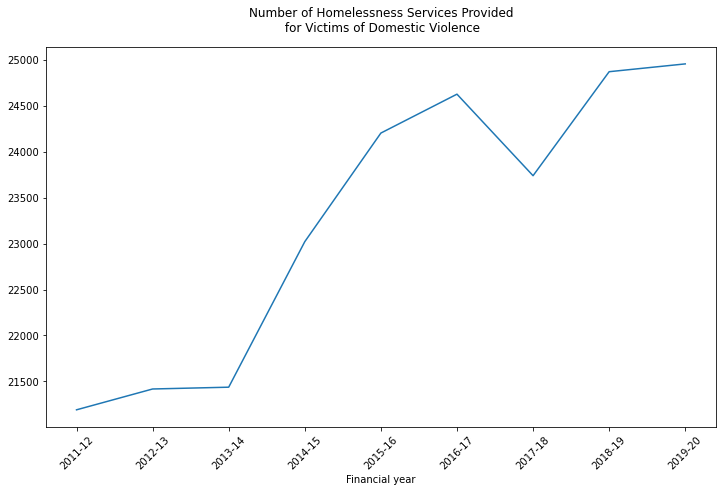

In [94]:
#plot number of services provided
WAhomelesstotal.plot(figsize=(12,7))
plt.xticks(rotation=45)
plt.title('Number of Homelessness Services Provided\n for Victims of Domestic Violence', pad = 15)
plt.show()